In [42]:
from __future__ import absolute_import
from __future__ import print_function

import os # Configure which GPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import sys
import random
import torch
import torch.nn as nn

sys.path.append(os.getcwd())
from utils.NN_utils import BeamPredictionModel, BlockPredictionModel, BestGainPredictionModel
from utils.NN_utils import BeamPredictionLSTMModel, BlockPredictionLSTMModel, BestGainPredictionLSTMModel
from utils.NN_utils import preprocess_data
from utils.options import args_parser
from utils.mox_utils import setup_seed, get_save_dirs, np2torch, save_NN_results
from utils.data_utils import get_prepared_dataset, prepare_dataset
from utils.beam_utils import generate_dft_codebook, beamIdPair_to_beamPairId, beamPairId_to_beamIdPair
from utils.NN_utils import BeamPredictionModel, train_beampred_lstm_model
from utils.options import args_parser
from utils.mox_utils import setup_seed, get_save_dirs, save_NN_results
from utils.plot_utils import plot_record_metrics
from utils.data_utils import get_prepared_dataset, prepare_dataset, augment_dataset
from utils.beam_utils import generate_dft_codebook

%matplotlib inline

In [43]:
# 为灵活修改plots中的strategy的名字,定义如下字典
change_strategyName_dict = dict()
change_strategyName_dict['ME-COBRA (PredInfo)'] = 'MEET-COBRA (PredInfo)'
change_strategyName_dict['ME-COBRA (TrueInfo)'] = 'MEET-COBRA (TrueInfo)'
change_strategyName_dict['ME-COBRA (NoBF)'] = 'MEET-COBRA (NoBF)'

## Exp 1: diffHO

In [44]:
result_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp1/lbd1.00_800_950_2025-09-30 08:19:00/sim_result_dict.npy"
with open(result_path, 'rb') as f:
    sim_result_dict = np.load(f, allow_pickle=True).item()
args = sim_result_dict.pop('args')
data_rate_list = sim_result_dict.pop('data_rate_list')

# 修改strategy的名字
new_sim_result_dict = dict()
for k,v in sim_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_sim_result_dict[change_strategyName_dict[k]] = v
    else:
        new_sim_result_dict[k] = v
        
sim_result_dict = new_sim_result_dict
strategy_name_list = list(sim_result_dict.keys())
print('strategy_name_list: ',strategy_name_list)
avg_car_num = sim_result_dict[strategy_name_list[0]]['carnum_under_BS_list'][0].sum(-1).mean()

strategy_name_list:  ['MEET-COBRA (PredInfo)', 'MEET-COBRA (TrueInfo)', 'MEET-COBRA (NoBF)', 'GreedyPHO (PredInfo)', 'GreedyPHO (TrueInfo)', 'GreedyPHO (NoBF)']


<Figure size 640x480 with 0 Axes>

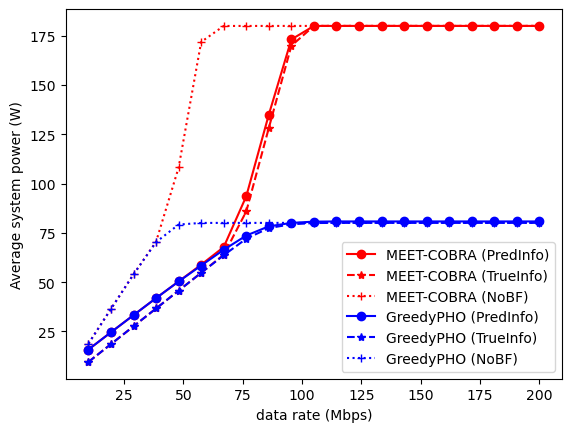

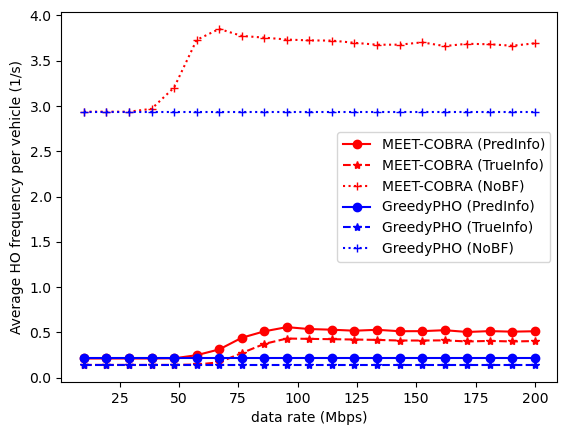

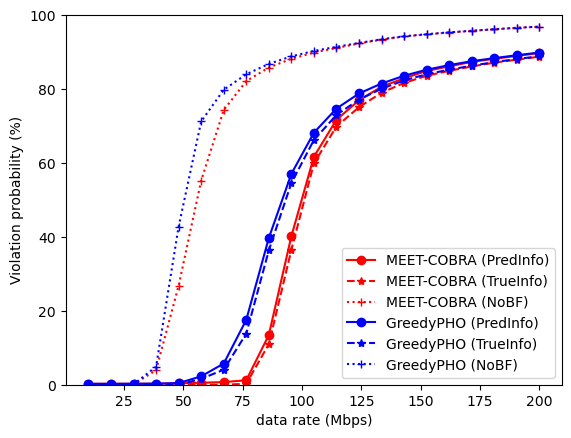

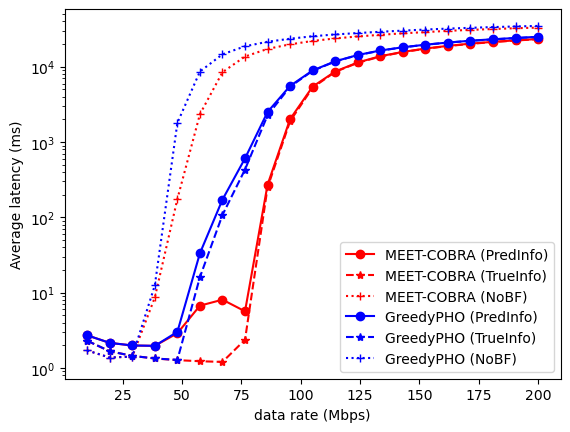

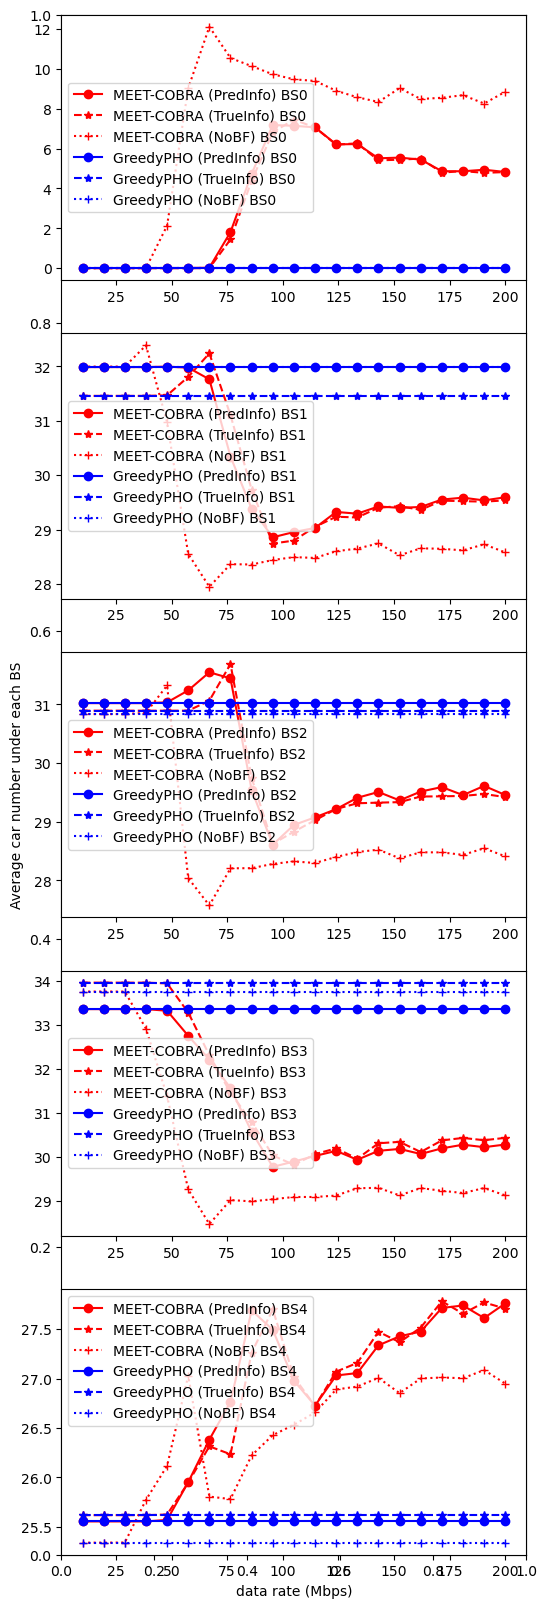

In [45]:
colorlist = ['red', 'red', 'red', 'blue', 'blue', 'blue',]
markerlist = ['o', '*', '+', 'o', '*', '+', ]
linestylelist = ['solid', 'dashed', 'dotted','solid', 'dashed', 'dotted',]
colordict = {}
markerdict = {}
linestyledict = {}
for idx, strategy_name in enumerate(strategy_name_list):
    colordict[strategy_name] = colorlist[idx]
    markerdict[strategy_name] = markerlist[idx]
    linestyledict[strategy_name] = linestylelist[idx]

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["avg_system_power_list"],
        # "*-",
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylabel("Average system power (W)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        np.array(sim_result_dict[strategy_name]["HOps_list"]) / avg_car_num,
        # "*-",
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylabel("Average HO frequency per vehicle (1/s)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["vio_prob_list"],
        # "*-",
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylim(0, 100)
plt.ylabel("Violation probability (%)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["avg_latency_list"],
        # "*-",
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.yscale("log")
plt.ylabel("Average latency (ms)")
plt.show()

plt.figure(figsize=(6, 4*5))
plt.xlabel("data rate (Mbps)")
plt.ylabel("Average car number under each BS")
for BS_id in range(5):
    plt.subplot(5, 1, BS_id + 1)
    for strategy_name in strategy_name_list:
        avg_carnum_under_BS_list = np.array(sim_result_dict[strategy_name]["carnum_under_BS_list"]).mean(axis=-2)
        plt.plot(
            data_rate_list/1e6,
            avg_carnum_under_BS_list[:, BS_id],
            marker=markerdict[strategy_name],
            linestyle=linestyledict[strategy_name],
            color=colordict[strategy_name],
            label=f"{strategy_name} BS{BS_id}",
        )
    plt.legend()
plt.show()

## Exp 2: diffRA

In [46]:
result_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp2/lbd1.00_800_950_2025-09-30 08:19:15/sim_result_dict.npy"
with open(result_path, 'rb') as f:
    sim_result_dict = np.load(f, allow_pickle=True).item()
args = sim_result_dict.pop('args')
data_rate_list = sim_result_dict.pop('data_rate_list')

# 修改strategy的名字
new_sim_result_dict = dict()
for k,v in sim_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_sim_result_dict[change_strategyName_dict[k]] = v
    else:
        new_sim_result_dict[k] = v
        
sim_result_dict = new_sim_result_dict
strategy_name_list = list(sim_result_dict.keys())
print('strategy_name_list: ',strategy_name_list)
avg_car_num = sim_result_dict[strategy_name_list[0]]['carnum_under_BS_list'][0].sum(-1).mean()


strategy_name_list:  ['MEET-COBRA (PredInfo)', 'MEET-COBRA (TrueInfo)', 'MEET-COBRA (NoBF)', 'PropFair (PredInfo)', 'PropFair (TrueInfo)', 'PropFair (NoBF)']


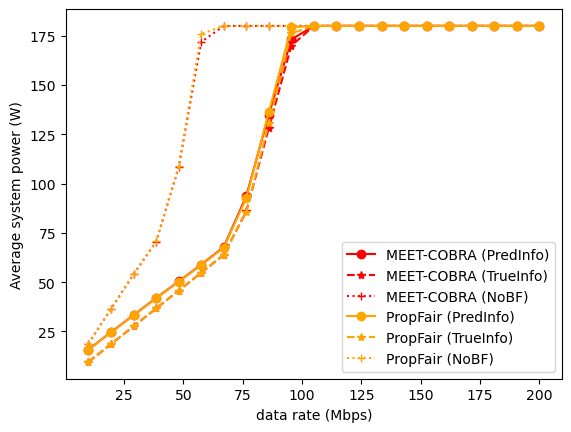

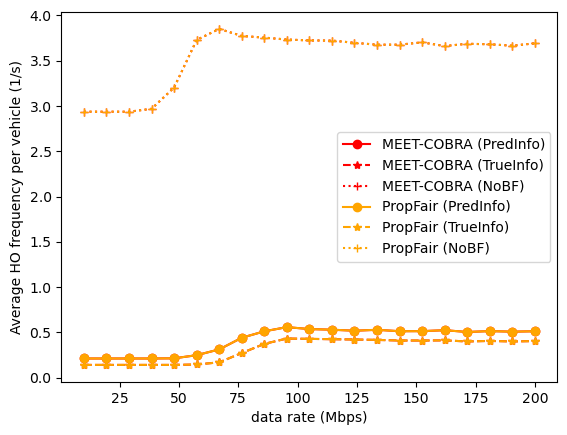

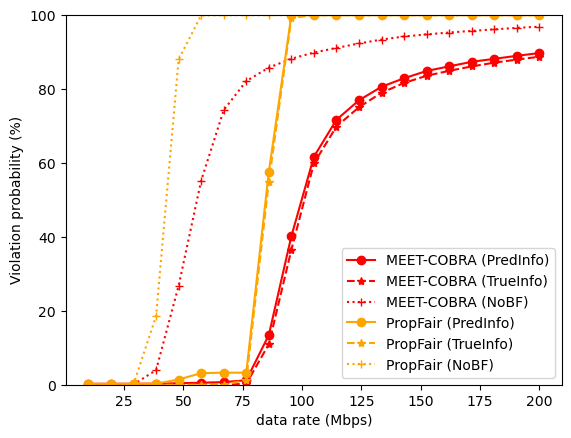

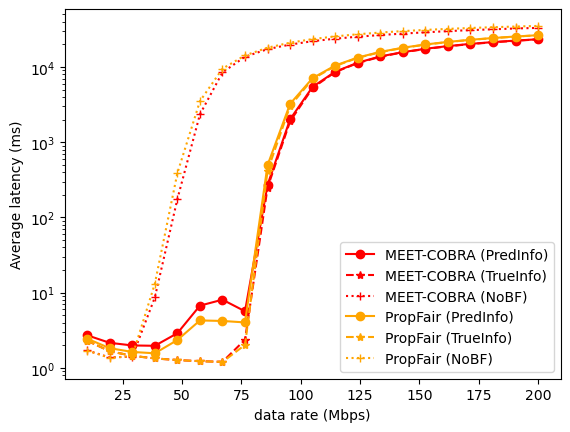

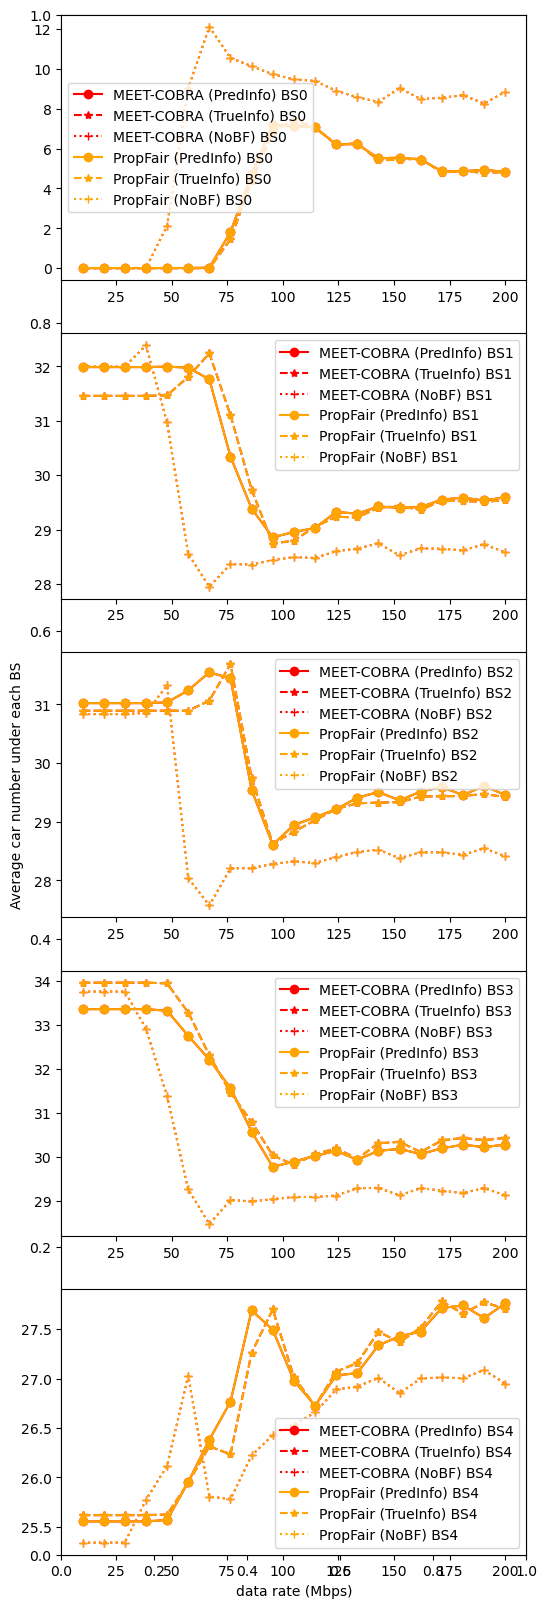

In [47]:
colorlist = ['red', 'red', 'red', 'orange', 'orange', 'orange',]
markerlist = ['o', '*', '+', 'o', '*', '+', ]
linestylelist = ['solid', 'dashed', 'dotted','solid', 'dashed', 'dotted',]
colordict = {}
markerdict = {}
linestyledict = {}
for idx, strategy_name in enumerate(strategy_name_list):
    colordict[strategy_name] = colorlist[idx]
    markerdict[strategy_name] = markerlist[idx]
    linestyledict[strategy_name] = linestylelist[idx]
    
plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["avg_system_power_list"],
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylabel("Average system power (W)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        np.array(sim_result_dict[strategy_name]["HOps_list"]) / avg_car_num,
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylabel("Average HO frequency per vehicle (1/s)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["vio_prob_list"],
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.ylim(0, 100)
plt.ylabel("Violation probability (%)")
plt.show()

plt.figure()
for strategy_name in strategy_name_list:
    plt.plot(
        data_rate_list/1e6,
        sim_result_dict[strategy_name]["avg_latency_list"],
        marker=markerdict[strategy_name],
        linestyle=linestyledict[strategy_name],
        color=colordict[strategy_name],
        label=strategy_name,
    )
plt.legend()
plt.xlabel("data rate (Mbps)")
# plt.xscale("log")
plt.yscale("log")
plt.ylabel("Average latency (ms)")
plt.show()

plt.figure(figsize=(6, 4*5))
plt.xlabel("data rate (Mbps)")
plt.ylabel("Average car number under each BS")
for BS_id in range(5):
    plt.subplot(5, 1, BS_id + 1)
    for strategy_name in strategy_name_list:
        avg_carnum_under_BS_list = np.array(sim_result_dict[strategy_name]["carnum_under_BS_list"]).mean(axis=-2)
        plt.plot(
            data_rate_list/1e6,
            avg_carnum_under_BS_list[:, BS_id],
            marker=markerdict[strategy_name],
            linestyle=linestyledict[strategy_name],
            color=colordict[strategy_name],
            label=f"{strategy_name} BS{BS_id}",
        )
    plt.legend()
plt.show()

## Exp 3: diffNp

Np_list:  [1, 2, 4, 8, 16, 32]
KPI_name_list:  ['best_epoch', 'best_train_acc', 'best_val_acc', 'best_train_top3_acc', 'best_val_top3_acc']


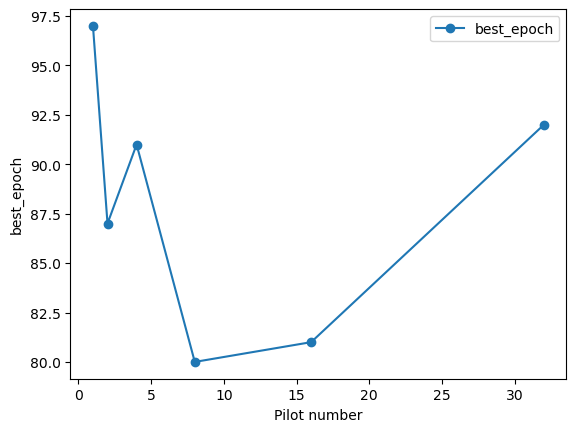

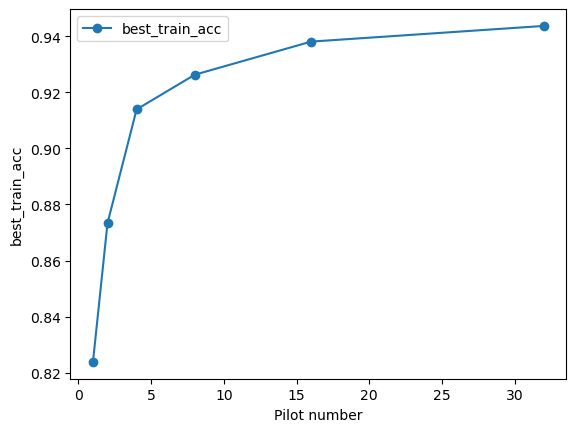

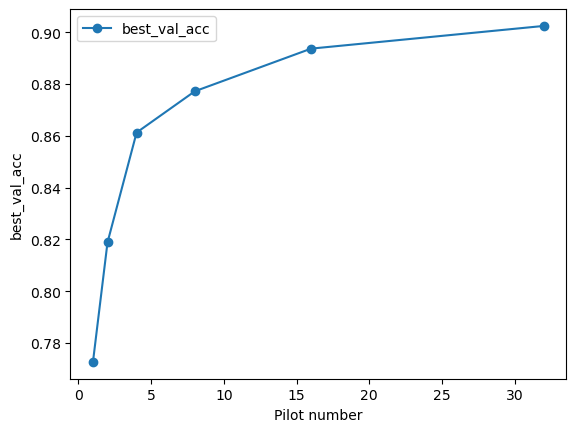

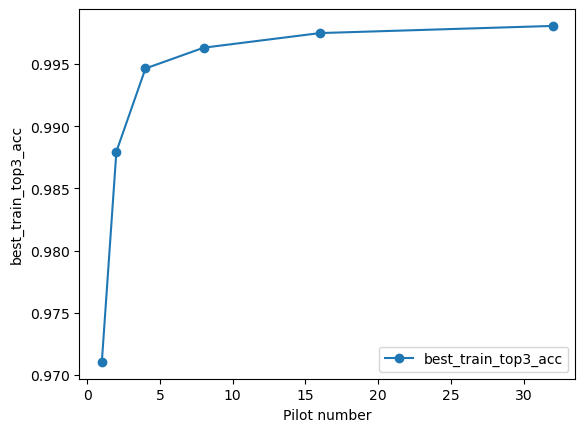

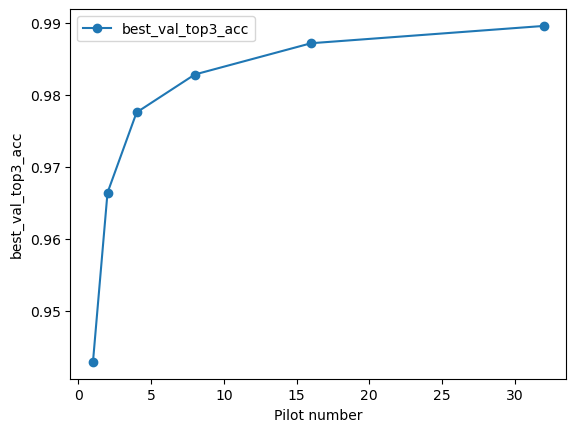

In [48]:
bestKPI_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp3/lbd1.00_datasize640250_beampred_2025-09-19 07:39:47/bestKPI_dict.npy"
best_model_weights_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp3/lbd1.00_datasize640250_2025-09-19 07:39:47/best_model_weights_list.npy"

with open(bestKPI_path, 'rb') as f:
    sim_result_dict = np.load(f, allow_pickle=True).item()

# 修改strategy的名字
new_sim_result_dict = dict()
for k,v in sim_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_sim_result_dict[change_strategyName_dict[k]] = v
    else:
        new_sim_result_dict[k] = v
        
bestKPI_dict = new_sim_result_dict
Np_list = sorted(list(bestKPI_dict.keys()))
print('Np_list: ',Np_list)
KPI_name_list = list(bestKPI_dict[Np_list[0]].keys())
print('KPI_name_list: ',KPI_name_list)
for KPI_name in KPI_name_list:
    plt.figure()
    alist = [bestKPI_dict[Np][KPI_name] for Np in Np_list]
    plt.plot(Np_list, alist, marker='o', label=KPI_name)
    plt.legend()
    plt.xlabel("Pilot number")
    # plt.xscale("log")
    plt.ylabel(KPI_name)
    plt.show()



Np_list:  [1, 2, 4, 8, 16, 32]
KPI_name_list:  ['best_epoch', 'best_train_rmse', 'best_val_rmse', 'best_train_mae', 'best_val_mae']


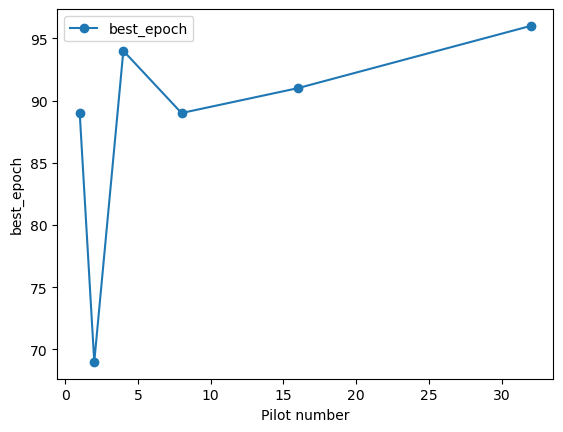

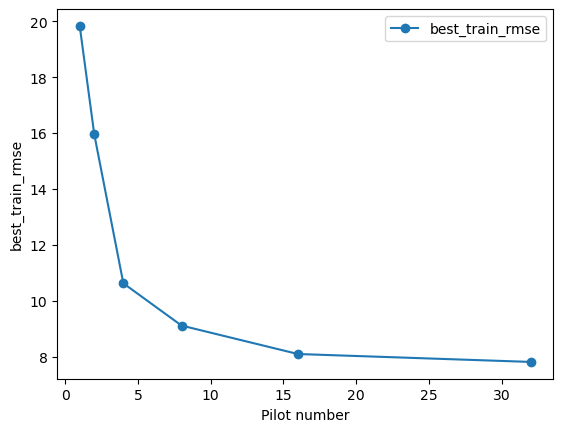

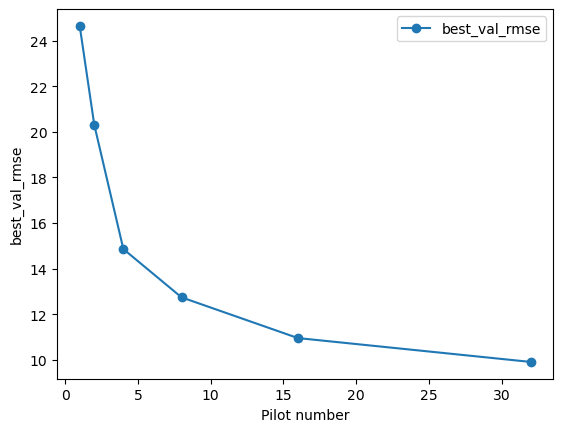

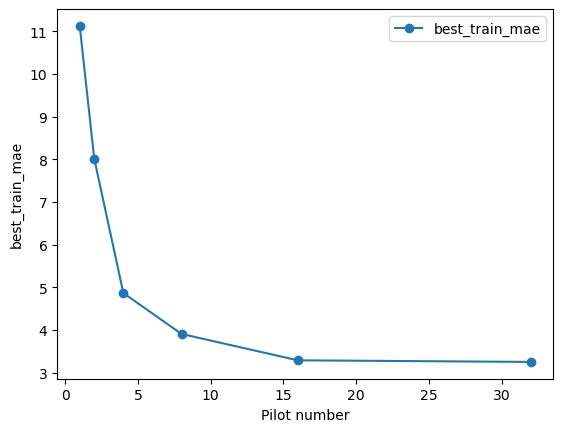

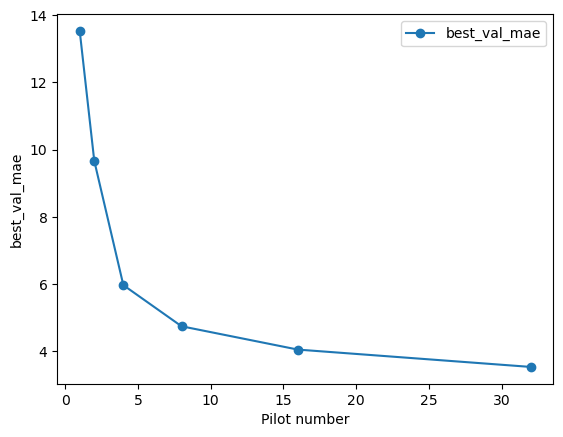

In [49]:
bestKPI_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp3/lbd1.00_datasize640250_gainpred_2025-10-01 01:12:13/bestKPI_dict.npy"
best_model_weights_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp3/lbd1.00_datasize640250_gainpred_2025-10-01 01:12:13/best_model_weights_list.npy"

with open(bestKPI_path, 'rb') as f:
    sim_result_dict = np.load(f, allow_pickle=True).item()

# 修改strategy的名字
new_sim_result_dict = dict()
for k,v in sim_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_sim_result_dict[change_strategyName_dict[k]] = v
    else:
        new_sim_result_dict[k] = v
        
bestKPI_dict = new_sim_result_dict
Np_list = sorted(list(bestKPI_dict.keys()))
print('Np_list: ',Np_list)
KPI_name_list = list(bestKPI_dict[Np_list[0]].keys())
print('KPI_name_list: ',KPI_name_list)
for KPI_name in KPI_name_list:
    plt.figure()
    alist = [bestKPI_dict[Np][KPI_name] for Np in Np_list]
    plt.plot(Np_list, alist, marker='o', label=KPI_name)
    plt.legend()
    plt.xlabel("Pilot number")
    # plt.xscale("log")
    plt.ylabel(KPI_name)
    plt.show()



## Exp 4: diffInputLen

Np_list:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
KPI_name_list:  ['val_loss', 'val_acc', 'val_top3_acc']


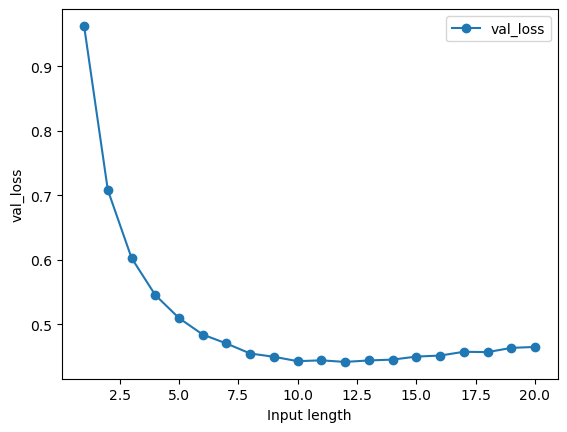

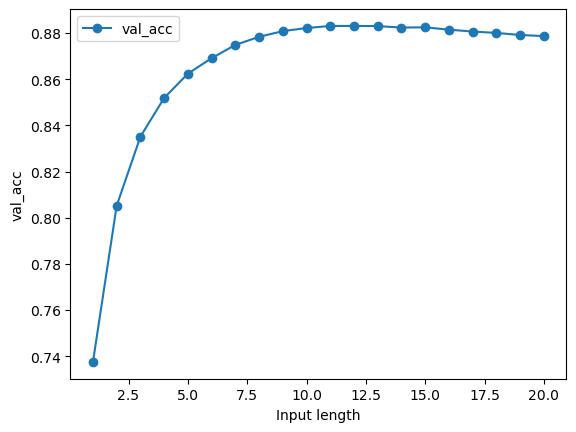

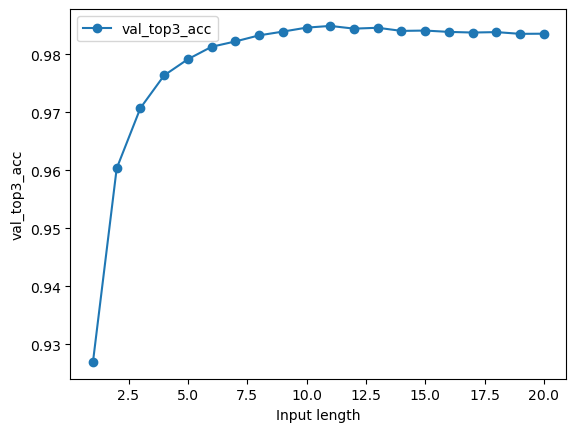

In [55]:
beam_metrics_dict = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp4/lbd1.00_datasize177590_2025-10-03 10:32:59/beam_metrics_dict.npy"
with open(beam_metrics_dict, 'rb') as f:
    beam_result_dict = np.load(f, allow_pickle=True).item()
# 修改strategy的名字
new_beam_result_dict = dict()
for k,v in beam_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_beam_result_dict[change_strategyName_dict[k]] = v
    else:
        new_beam_result_dict[k] = v
bestKPI_dict = new_beam_result_dict
Np_list = sorted(list(bestKPI_dict.keys()))
print('Np_list: ',Np_list)
KPI_name_list = list(bestKPI_dict[Np_list[0]].keys())
print('KPI_name_list: ',KPI_name_list)
for KPI_name in KPI_name_list:
    plt.figure()
    alist = [bestKPI_dict[Np][KPI_name] for Np in Np_list]
    plt.plot(Np_list, alist, marker='o', label=KPI_name)
    plt.legend()
    plt.xlabel("Input length")
    # plt.xscale("log")
    plt.ylabel(KPI_name)
    plt.show()



Np_list:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
KPI_name_list:  ['val_loss', 'val_mae', 'val_mse', 'val_rmse']


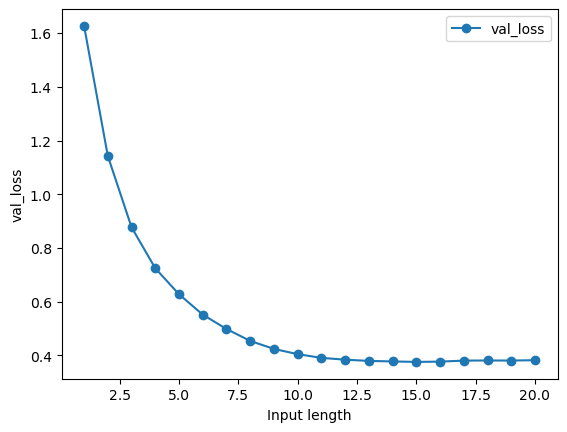

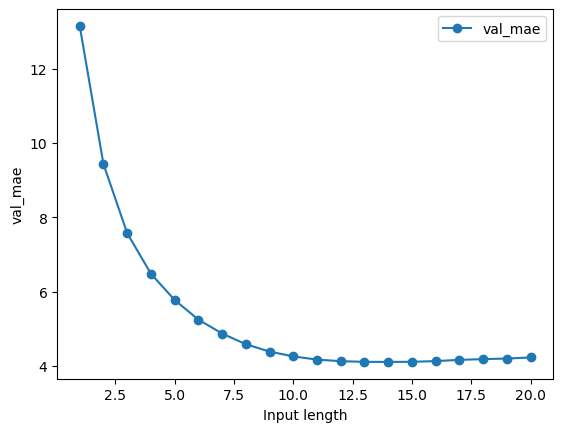

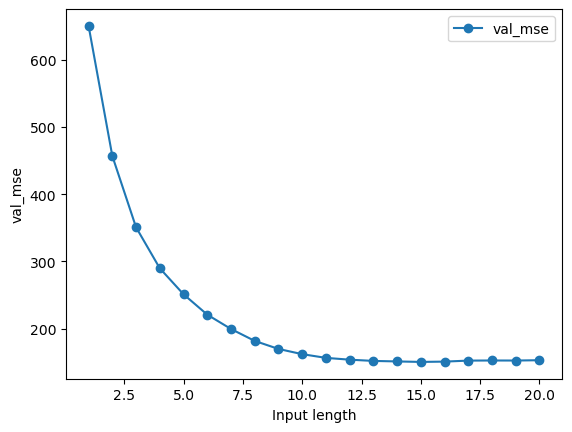

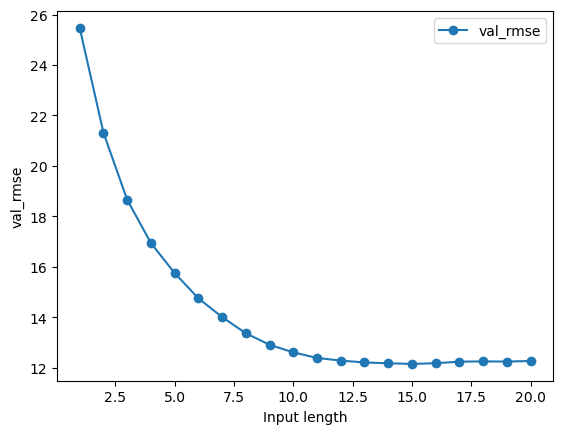

In [56]:
gain_metrics_dict = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp4/lbd1.00_datasize177590_2025-10-03 10:32:59/gain_metrics_dict.npy"
with open(gain_metrics_dict, 'rb') as f:
    gain_result_dict = np.load(f, allow_pickle=True).item()

# 修改strategy的名字
new_gain_result_dict = dict()
for k,v in gain_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_gain_result_dict[change_strategyName_dict[k]] = v
    else:
        new_gain_result_dict[k] = v
for k,v in gain_result_dict.items():
    if k in change_strategyName_dict.keys():
        new_gain_result_dict[change_strategyName_dict[k]] = v
    else:
        new_gain_result_dict[k] = v

bestKPI_dict = new_gain_result_dict
Np_list = sorted(list(bestKPI_dict.keys()))
print('Np_list: ',Np_list)
KPI_name_list = list(bestKPI_dict[Np_list[0]].keys())
print('KPI_name_list: ',KPI_name_list)
for KPI_name in KPI_name_list:
    plt.figure()
    alist = [bestKPI_dict[Np][KPI_name] for Np in Np_list]
    plt.plot(Np_list, alist, marker='o', label=KPI_name)
    plt.legend()
    plt.xlabel("Input length")
    # plt.xscale("log")
    plt.ylabel(KPI_name)
    plt.show()



## Exp 5: diff K for beampred

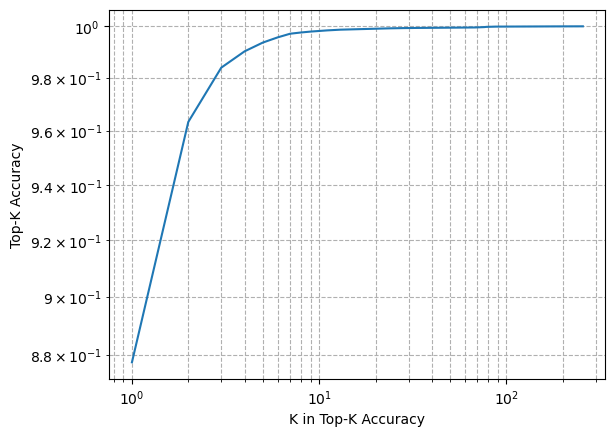

In [52]:
beam_metrics_dict_path = "/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp5/lbd1.00_datasize124995_2025-09-25 13:43:57/beam_metrics.npy"
with open(beam_metrics_dict_path, 'rb') as f:
    beam_metrics_dict = np.load(f, allow_pickle=True).item()
# 修改strategy的名字
new_beam_metrics_dict = dict()
for k,v in beam_metrics_dict.items():
    if k in change_strategyName_dict.keys():
        new_beam_metrics_dict[change_strategyName_dict[k]] = v
    else:
        new_beam_metrics_dict[k] = v
beam_metrics = new_beam_metrics_dict
M_t = 32
M_r = 8
num_beampair = M_r * M_t
plt.figure()
plt.plot(np.arange(1, num_beampair+1), beam_metrics['val_topK_acc_list'])
plt.xlabel("K in Top-K Accuracy")
plt.ylabel("Top-K Accuracy")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.show()

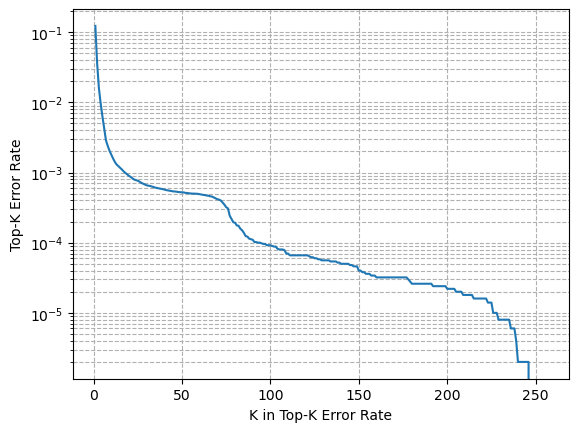

In [53]:
plt.figure()
plt.plot(np.arange(1, num_beampair+1), 1-beam_metrics['val_topK_acc_list'])
plt.xlabel("K in Top-K Error Rate")
plt.ylabel("Top-K Error Rate")
# plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.show()

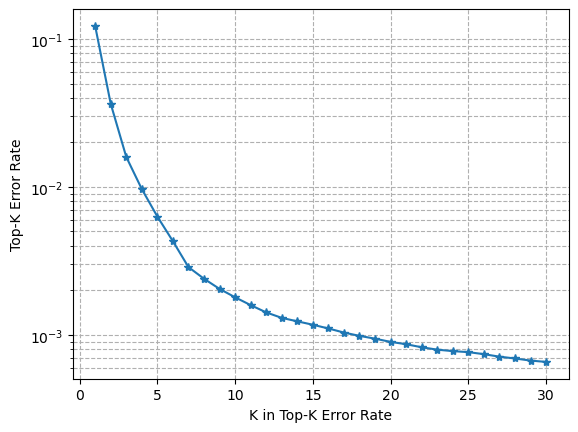

In [57]:
maxK = 30
plt.figure()
plt.plot(np.arange(1, num_beampair+1)[:maxK], 1-beam_metrics['val_topK_acc_list'][:maxK], '-*')
plt.xlabel("K in Top-K Error Rate")
plt.ylabel("Top-K Error Rate")
# plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.show()

In [58]:
with open('/home/ubuntu/niulab/Meet_Cobra/experiment/results_exp1/lbd1.00_800_950_2025-09-30 08:19:00/sim_result_dict.npy', 'rb') as f:
    sim_result_dict = np.load(f, allow_pickle=True).item()

In [66]:
sim_result_dict['ME-COBRA (PredInfo)']['avg_pilot_list']

[914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024,
 914.1503006012024]

In [72]:
sim_result_dict['ME-COBRA (PredInfo)']['carnum_under_BS_list'][0].sum(axis=-1).mean()

121.92256341789052

In [73]:
914.1503006012024 / 121.92256341789052

7.497794296433428